# HR 데이터를 활용한 직원 이탈 요인 분석
## 1.  데이터 확인 및 분석 프로세스 수집

사용 데이터: Kaggle의 `IBM HR Analytics Employee Attrition & Performance` 데이터  
- 데이터: https://www.kaggle.com/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/download?datasetVersionNumber=1

데이터 항목
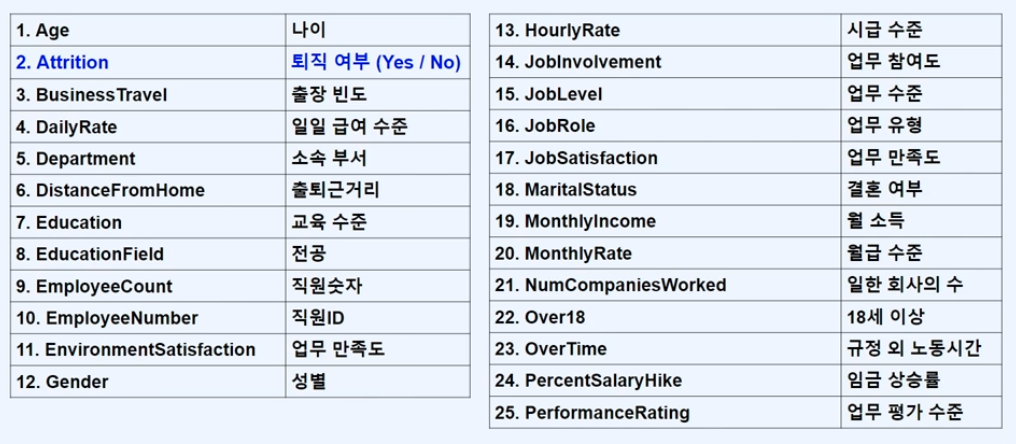   
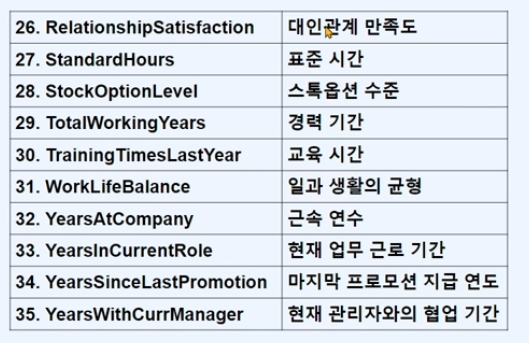  
Target Feature = Attrition

분석 목표: HR 데이터를 활용한 주요 직원 이탈 요인 분석

## 2. 데이터 준비를 위한 EDA 및 전처리

In [1]:
! apt-get update -qq
! apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'
font_name = 'NanumGothic'
fe = fm.FontEntry(fname=path, name=font_name)
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 10, 'font.family': font_name})

Selecting previously unselected package fonts-nanum.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-3_all.deb ...
Unpacking fonts-nanum-coding (2.5-3) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-7_all.deb ...
Unpacking fonts-nanum-eco (1.000-7) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20200506-1_all.deb ...
Unpacking fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum-extra (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Setting up fonts-nanum-coding (2.5-3) ...
Setting up fonts-nanum-eco (1.000-7) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


### 1. 데이터 불러오기

In [2]:
##### 필요한 파이썬 라이브러리 불러오기 #####
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, log_loss, classification_report)
from imblearn.over_sampling import SMOTE
import xgboost

from scipy.stats import pearsonr, chi2_contingency    # 상관성 분석 시에 숫자형 변수 간에는 pearsonr 상관 계수를 씀
from itertools import combinations
from statsmodels.stats.proportion import proportion_confint

#Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
attrition = pd.read_csv('/content/drive/MyDrive/MLStudy/Data_Anaylsis_And_Machine_Learning/04_analyzing_reason_of_employee_leaving_with_HR_data/WA_Fn-UseC_-HR-Employee-Attrition.csv')
attrition.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
# 데이터의 모양 알아보기
print(attrition.shape)

(1470, 35)


### 2. 데이터 탐색
#### 1) 변수간 관계 시각화
##### KDE Plot
- Kunnel Density Estimator Plot
- Kunnel의 density를 plot에 나타냄

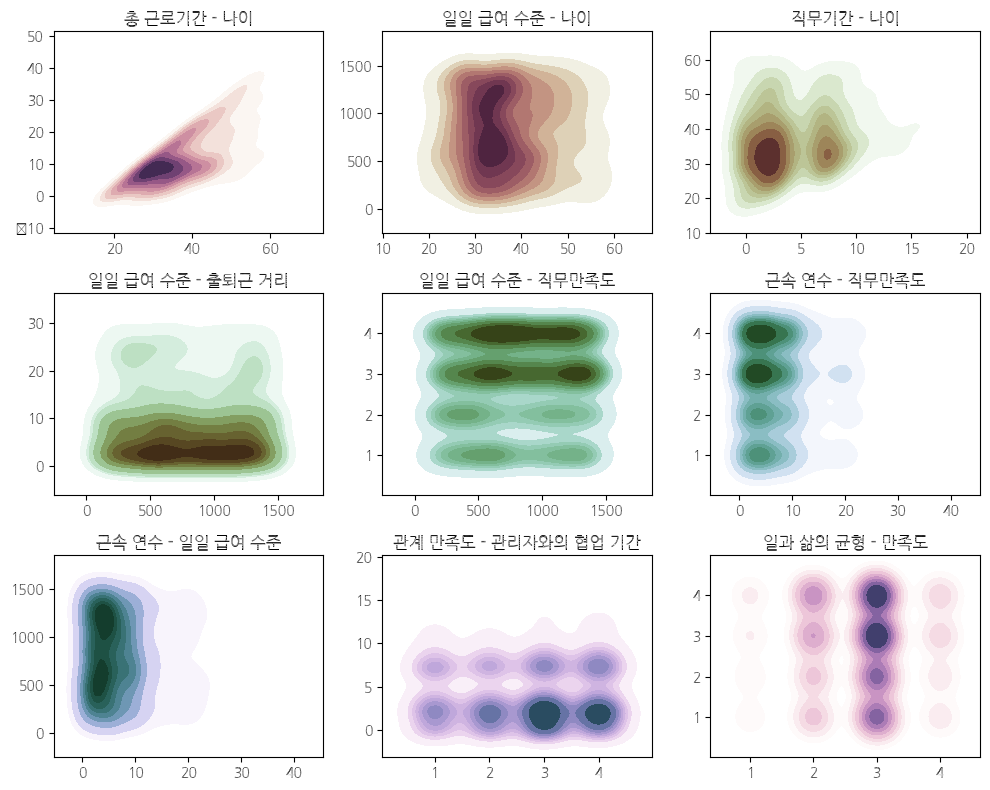

In [5]:
# 3*3 의 subplot을 그린 후에 주요 9개 변수에 대해서 서로간의 관계를 시각화

# 여러개의 KDE Plot 생성 준비
f, axes = plt.subplots(3, 3, figsize=(10, 8), sharex=False, sharey=False)

# Plot 색감 설정
s = np.linspace(0, 3, 10)
cmap = sns.cubehelix_palette(start=0.0, light=1, as_cmap=True)

x = attrition['Age'].values
y = attrition['TotalWorkingYears'].values
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, cut=5, ax=axes[0, 0])
axes[0, 0].set(title='총 근로기간 - 나이')
cmap = sns.cubehelix_palette(start=0.3333333333, light=1, as_cmap=True)

x = attrition['Age'].values
y = attrition['DailyRate'].values
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[0, 1])
axes[0, 1].set(title='일일 급여 수준 - 나이')
cmap = sns.cubehelix_palette(start=0.6666666667, light=1, as_cmap=True)

x = attrition['YearsInCurrentRole'].values
y = attrition['Age'].values
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[0, 2])
axes[0, 2].set(title='직무기간 - 나이')
cmap = sns.cubehelix_palette(start=1.0, light=1, as_cmap=True)

x = attrition['DailyRate'].values
y = attrition['DistanceFromHome'].values
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[1, 0])
axes[1, 0].set(title='일일 급여 수준 - 출퇴근 거리')
cmap = sns.cubehelix_palette(start=1.3333333333, light=1, as_cmap=True)

x = attrition['DailyRate'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[1, 1])
axes[1, 1].set(title='일일 급여 수준 - 직무만족도')
cmap = sns.cubehelix_palette(start=1.6666666667, light=1, as_cmap=True)

x = attrition['YearsAtCompany'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[1, 2])
axes[1, 2].set(title='근속 연수 - 직무만족도')
cmap = sns.cubehelix_palette(start=2.0, light=1, as_cmap=True)

x = attrition['YearsAtCompany'].values
y = attrition['DailyRate'].values
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[2, 0])
axes[2, 0].set(title='근속 연수 - 일일 급여 수준')
cmap = sns.cubehelix_palette(start=2.3333333333, light=1, as_cmap=True)

x = attrition['RelationshipSatisfaction'].values
y = attrition['YearsWithCurrManager'].values
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[2, 1])
axes[2, 1].set(title='관계 만족도 - 관리자와의 협업 기간')
cmap = sns.cubehelix_palette(start=2.6666666667, light=1, as_cmap=True)

x = attrition['WorkLifeBalance'].values
y = attrition['JobSatisfaction'].values
sns.kdeplot(x=x, y=y, cmap=cmap, shade=True, ax=axes[2, 2])
axes[2, 2].set(title='일과 삶의 균형 - 만족도')
cmap = sns.cubehelix_palette(start=3.0, light=1, as_cmap=True)

f.tight_layout()

### 3. 데이터 전처리
- 결측값 처리
- 중복값 처리


#### 1) 결측값 처리

In [6]:
# 결측값 확인
display(attrition.isnull().any())   # 모든게 False이므로 결측값 없음

Age                         False
Attrition                   False
BusinessTravel              False
DailyRate                   False
Department                  False
DistanceFromHome            False
Education                   False
EducationField              False
EmployeeCount               False
EmployeeNumber              False
EnvironmentSatisfaction     False
Gender                      False
HourlyRate                  False
JobInvolvement              False
JobLevel                    False
JobRole                     False
JobSatisfaction             False
MaritalStatus               False
MonthlyIncome               False
MonthlyRate                 False
NumCompaniesWorked          False
Over18                      False
OverTime                    False
PercentSalaryHike           False
PerformanceRating           False
RelationshipSatisfaction    False
StandardHours               False
StockOptionLevel            False
TotalWorkingYears           False
TrainingTimesL

#### 2) 중복값 처리

In [7]:
attrition.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
1465    False
1466    False
1467    False
1468    False
1469    False
Length: 1470, dtype: bool

In [8]:
# 중복된 항목 수 알아보기
print('중복된 항목 수: ', len(attrition[attrition.duplicated]))

중복된 항목 수:  0


### Target Feature 정의
- 방법 1: Pandas의 apply 이용
- 방법 2: y.isin([Target에 해당하는 컬럼들]).astype('int') 이용

In [9]:
# 퇴직 여부(Yes/No)에 따라 각각 1, 0으로 할당
target_map = {'Yes': 1, 'No': 0}

# pandas apply를 이용하여 퇴직 여부를 1, 0으로 표시한 새로운 컬럼 생성
attrition['Attrition_numerical'] = attrition['Attrition'].apply(lambda x: target_map[x])
attrition['Attrition_numerical'].value_counts()

0    1233
1     237
Name: Attrition_numerical, dtype: int64

In [10]:
y = attrition['Attrition'].copy()
y = y.isin(['Yes']).astype('int')
y.value_counts()

0    1233
1     237
Name: Attrition, dtype: int64

### 데이터 타입별 Feature 변환
#### 1) Feature 탐색
총 Feature 개수 확인


In [11]:
print(attrition.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

Feature 데이터 타입별 개수 확인

In [12]:
dtype_data = attrition.dtypes.reset_index()
dtype_data.columns = ['Count', 'Column Type']
dtype_data.head()

,Count,Column Type
0,Age,int64
1,Attrition,object
2,BusinessTravel,object
3,DailyRate,int64
4,Department,object


In [13]:
# 데이터 타입별 컬럼 수 확인
dtype_data = attrition.dtypes.reset_index()
dtype_data.columns = ['Count', 'Column Type']
dtype_data = dtype_data.groupby("Column Type").aggregate('count').reset_index()

print(dtype_data)

  Column Type  Count
0       int64     27
1      object      9


#### 2) 숫자형 Feature
- 데이터 확인
- Feature 제거
- Feature Skewness 확인

데이터 확인

In [14]:
# pandas의 select_dtypes('number') 사용
attrition.select_dtypes(include=['number']).head()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_numerical
0,41,1102,1,2,1,1,2,94,3,2,...,80,0,8,0,1,6,4,0,5,1
1,49,279,8,1,1,2,3,61,2,2,...,80,1,10,3,3,10,7,1,7,0
2,37,1373,2,2,1,4,4,92,2,1,...,80,0,7,3,3,0,0,0,0,1
3,33,1392,3,4,1,5,4,56,3,1,...,80,0,8,3,3,8,7,3,0,0
4,27,591,2,1,1,7,1,40,3,1,...,80,1,6,3,3,2,2,2,2,0


In [15]:
num_feat = attrition.select_dtypes(include=['number']).columns.values
attrition_num = attrition[num_feat].copy()
attrition_num

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_numerical
0,41,1102,1,2,1,1,2,94,3,2,...,80,0,8,0,1,6,4,0,5,1
1,49,279,8,1,1,2,3,61,2,2,...,80,1,10,3,3,10,7,1,7,0
2,37,1373,2,2,1,4,4,92,2,1,...,80,0,7,3,3,0,0,0,0,1
3,33,1392,3,4,1,5,4,56,3,1,...,80,0,8,3,3,8,7,3,0,0
4,27,591,2,1,1,7,1,40,3,1,...,80,1,6,3,3,2,2,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,884,23,2,1,2061,3,41,4,2,...,80,1,17,3,3,5,2,0,3,0
1466,39,613,6,1,1,2062,4,42,2,3,...,80,1,9,5,3,7,7,1,7,0
1467,27,155,4,3,1,2064,2,87,4,2,...,80,1,6,0,3,6,2,0,3,0
1468,49,1023,2,3,1,2065,4,63,2,2,...,80,0,17,3,2,9,6,0,8,0


Feature 제거
> Feature 별 유일한 값 개수 확인

In [16]:
# 결과가 1인 컬럼은 모두 같은 값을 가지고 있는 것이고 결과가 1470이면 사원번호처럼 모두 다른 값을 가지고 있는 것
print(attrition_num.nunique().sort_values())

EmployeeCount                  1
StandardHours                  1
Attrition_numerical            2
PerformanceRating              2
WorkLifeBalance                4
StockOptionLevel               4
EnvironmentSatisfaction        4
JobInvolvement                 4
JobSatisfaction                4
RelationshipSatisfaction       4
Education                      5
JobLevel                       5
TrainingTimesLastYear          7
NumCompaniesWorked            10
PercentSalaryHike             15
YearsSinceLastPromotion       16
YearsWithCurrManager          18
YearsInCurrentRole            19
DistanceFromHome              29
YearsAtCompany                37
TotalWorkingYears             40
Age                           43
HourlyRate                    71
DailyRate                    886
MonthlyIncome               1349
MonthlyRate                 1427
EmployeeNumber              1470
dtype: int64


In [17]:
print(attrition.shape)

(1470, 36)


유일한 값이 1개인 경우 또는 모든 행의 값이 다른 경우는 제거  
- Target Feature가 포함되어 있으면 함께 제거

In [18]:
attrition_num = attrition_num.drop(['StandardHours', 'EmployeeCount', 'EmployeeNumber'], axis=1, errors='ignore')

Feature Skewness 확인 (피쳐의 값이 어느 쪽으로 치우쳐져있는지)

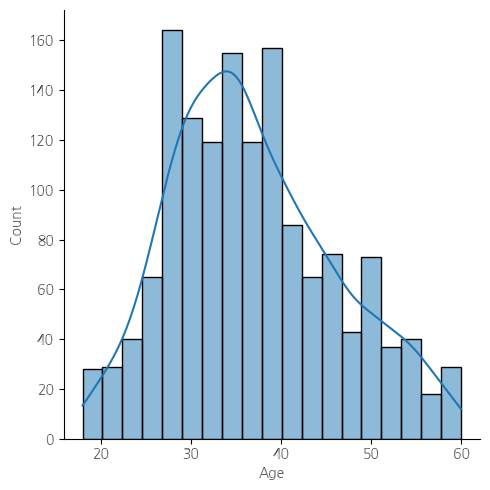

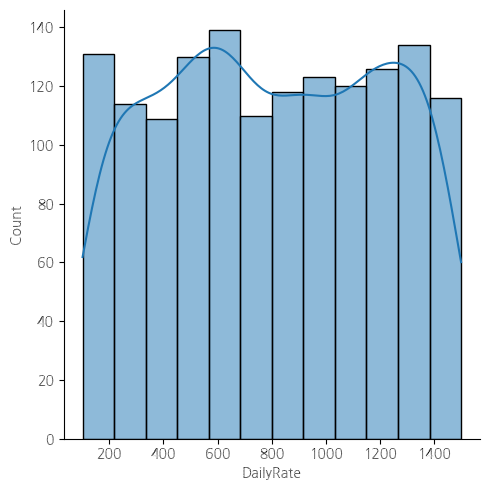

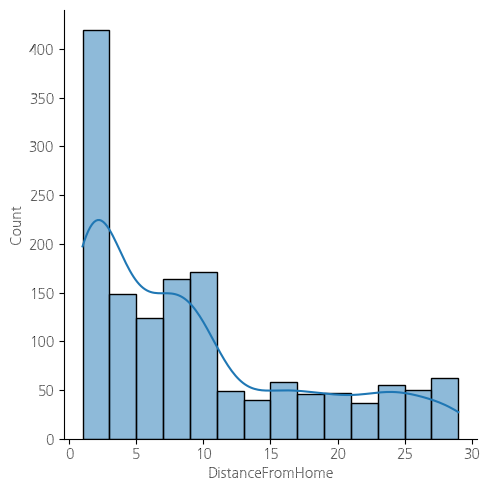

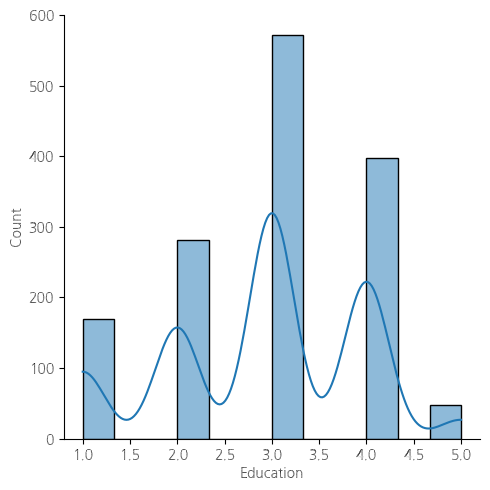

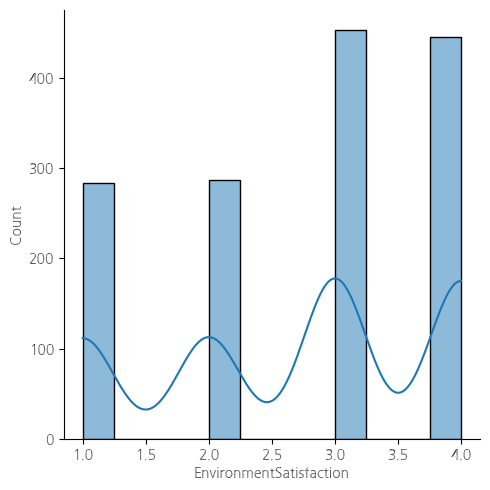

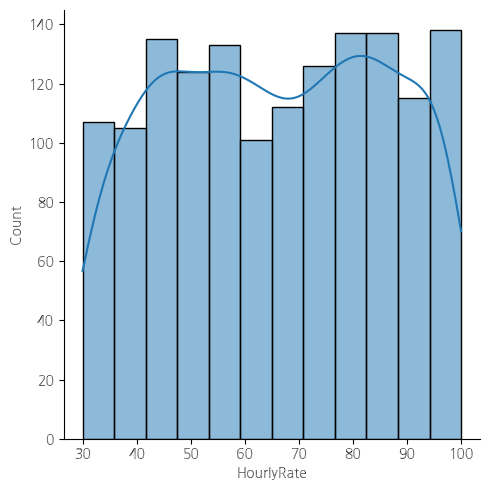

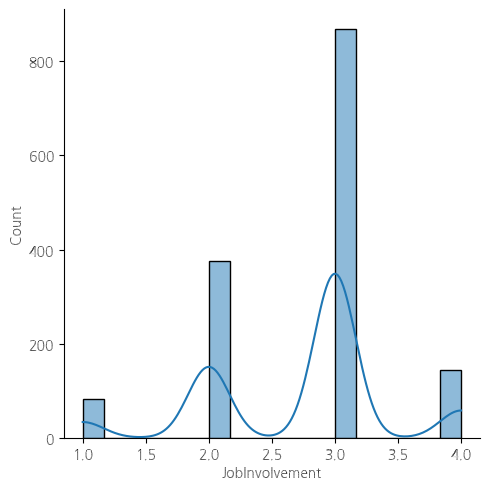

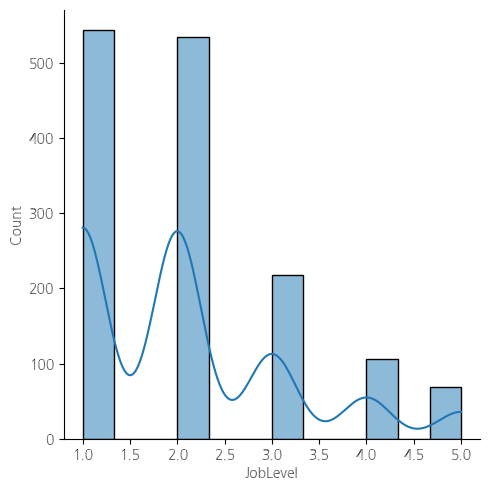

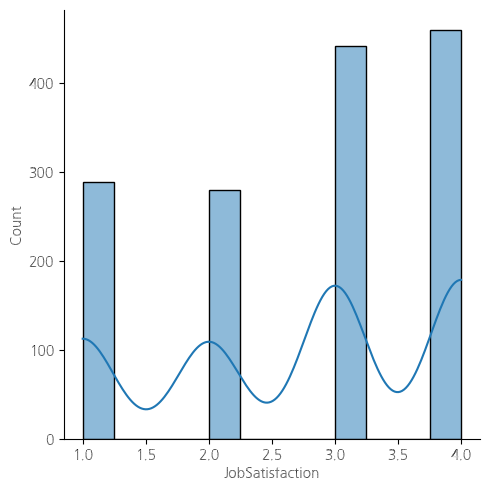

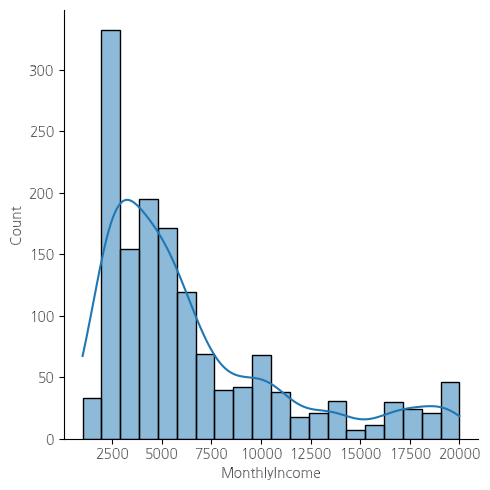

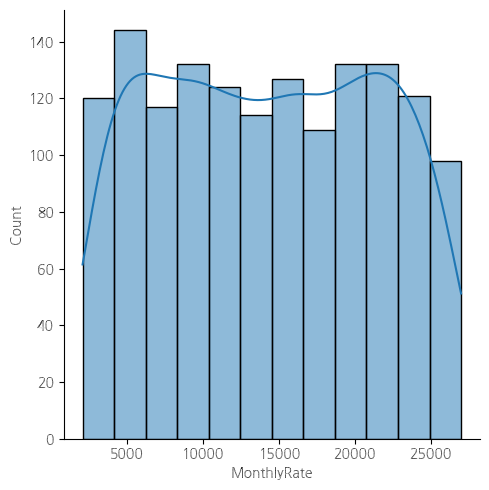

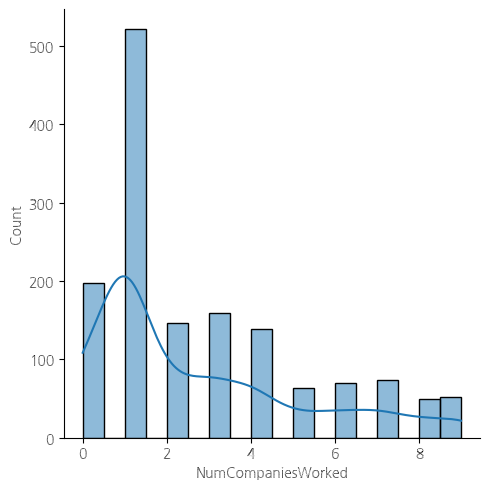

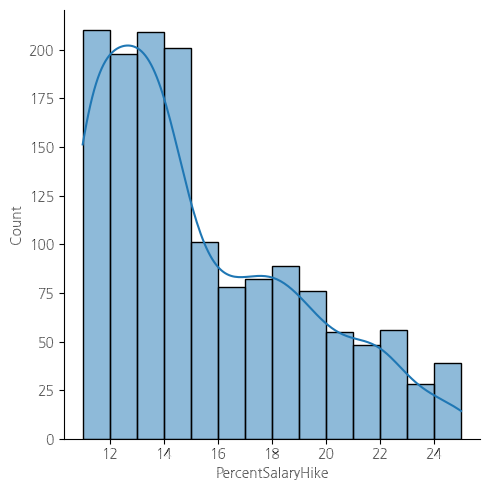

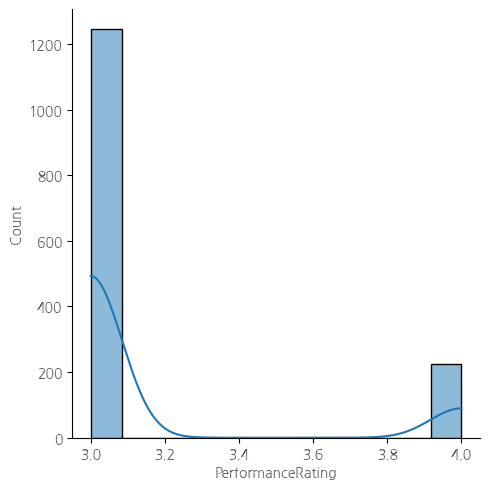

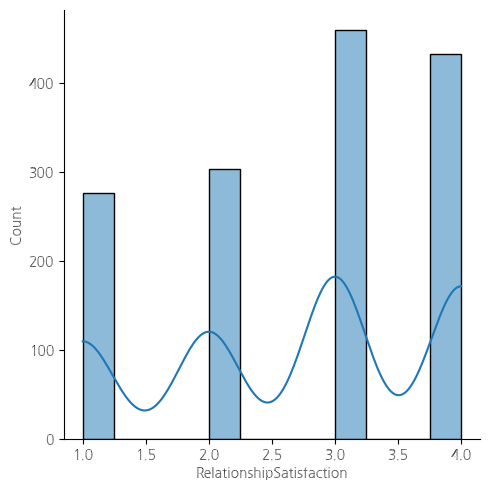

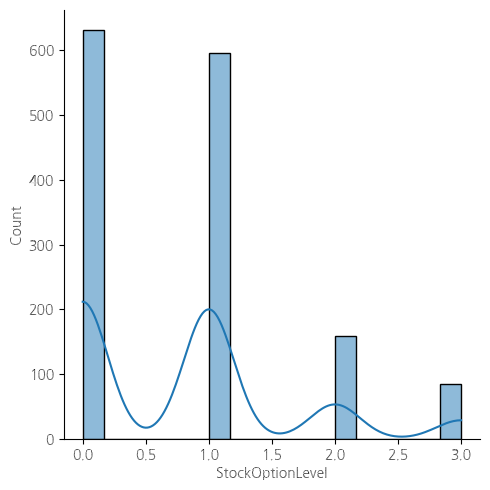

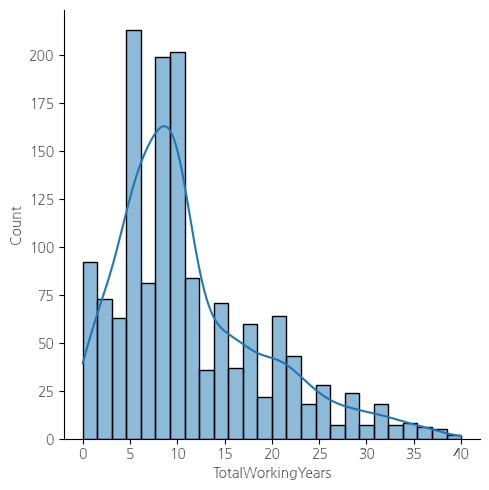

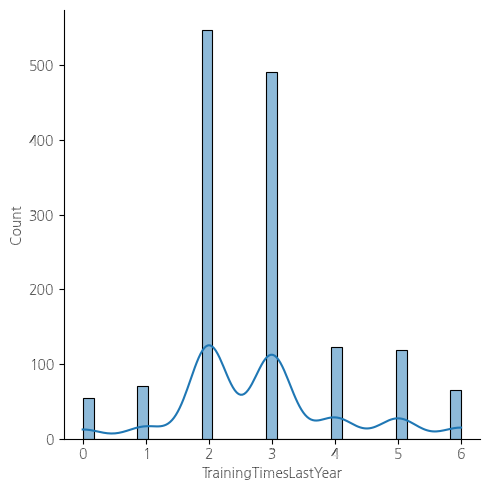

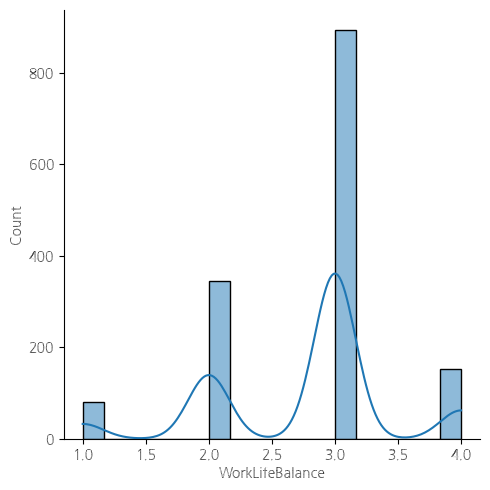

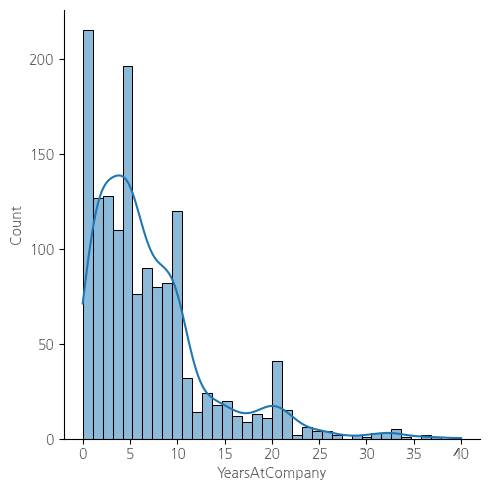

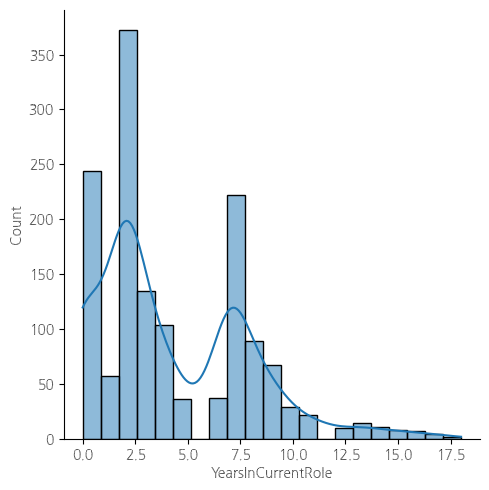

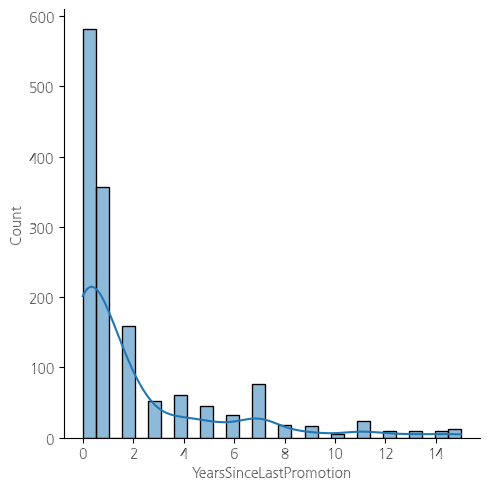

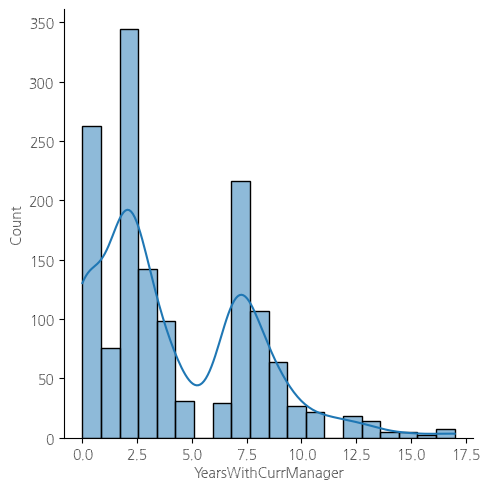

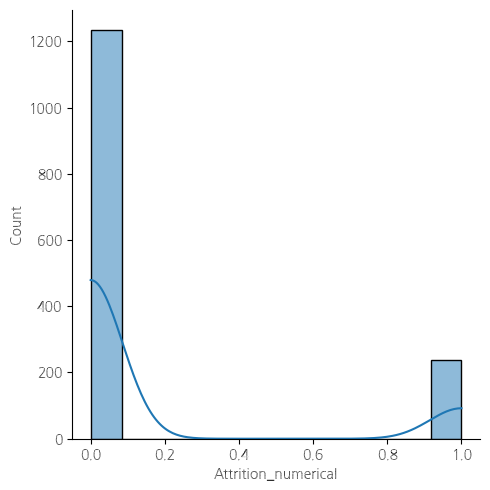

In [19]:
col_attrition_num = attrition_num.columns.values
for i in range(0, len(col_attrition_num)):
  sns.displot(attrition_num[col_attrition_num[i]], kde=True)

#### 3) 범주형 Feature
- 데이터 확인
- Feature 별 개수 시각화
- 날짜/숫자/기간 등으로 변환해야 할 항목이 있는지 확인
- Feature 별 개수 시각화
- Feature의 개수가 인코딩에 적합한가?

##### 데이터 확인

In [20]:
attrition.select_dtypes(include=['object', 'category']).head()

,Attrition,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,Over18,OverTime
0,Yes,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Y,Yes
1,No,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,Y,No
2,Yes,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Y,Yes
3,No,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Y,Yes
4,No,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,Y,No


Feature 제거
> Feature 별 유일한 값 개수 확인

In [21]:
cat_feat = attrition.select_dtypes('object', 'category').columns.values
attrition_cat = attrition[cat_feat].copy()
attrition_cat.nunique().sort_values()

Over18            1
Attrition         2
Gender            2
OverTime          2
BusinessTravel    3
Department        3
MaritalStatus     3
EducationField    6
JobRole           9
dtype: int64

> 유일한 값이 1개인 경우 또는 모든 행의 값이 다른 경우는 제거  
> - Target Feature가 포함되어 있으면 함께 제거 (Attrition 컬럼이 타겟 피쳐)

In [22]:
attrition_cat = attrition_cat.drop(['Over18', 'Attrition'], axis=1, errors='ignore')
attrition_cat

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
0,Travel_Rarely,Sales,Life Sciences,Female,Sales Executive,Single,Yes
1,Travel_Frequently,Research & Development,Life Sciences,Male,Research Scientist,Married,No
2,Travel_Rarely,Research & Development,Other,Male,Laboratory Technician,Single,Yes
3,Travel_Frequently,Research & Development,Life Sciences,Female,Research Scientist,Married,Yes
4,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Married,No
...,...,...,...,...,...,...,...
1465,Travel_Frequently,Research & Development,Medical,Male,Laboratory Technician,Married,No
1466,Travel_Rarely,Research & Development,Medical,Male,Healthcare Representative,Married,No
1467,Travel_Rarely,Research & Development,Life Sciences,Male,Manufacturing Director,Married,Yes
1468,Travel_Frequently,Sales,Medical,Male,Sales Executive,Married,No


Feature 별 개수 시각화

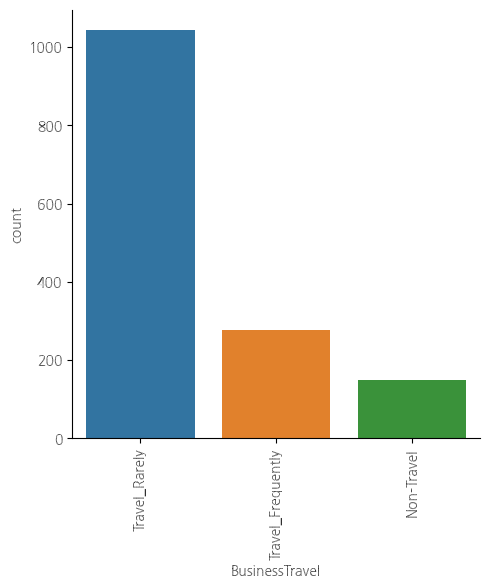

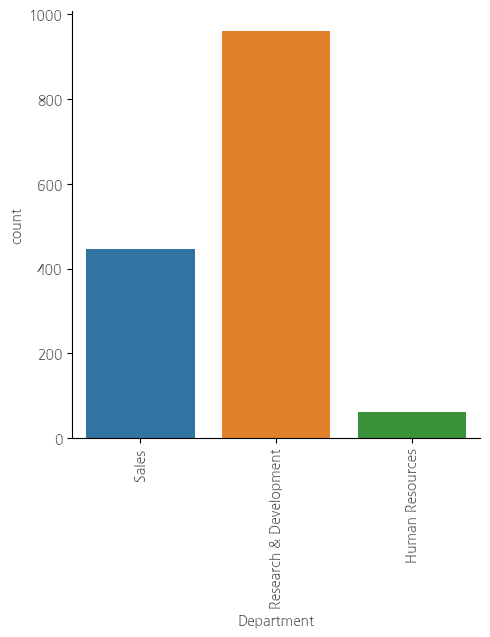

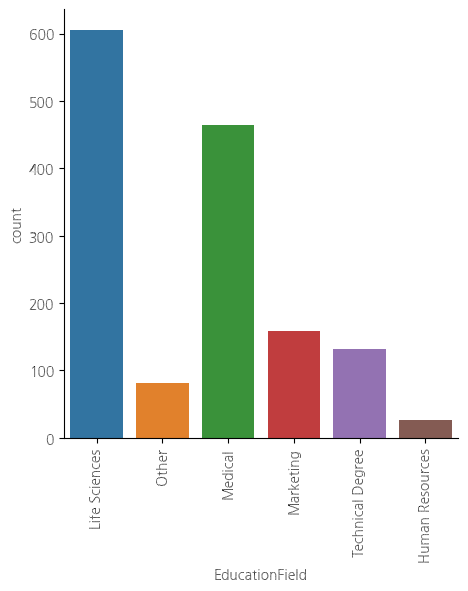

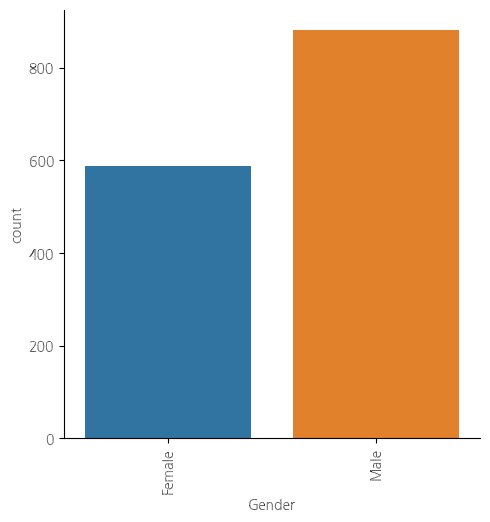

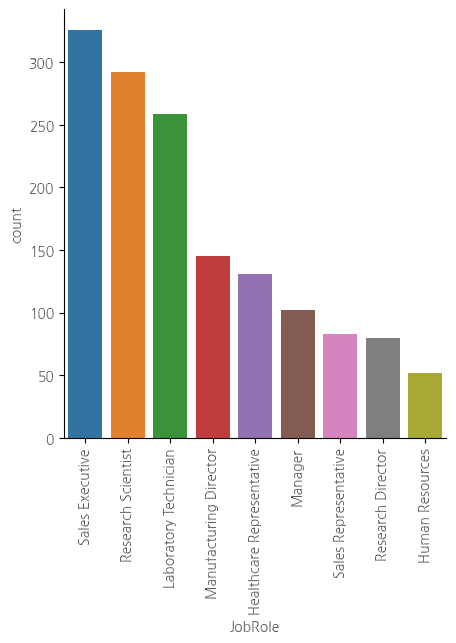

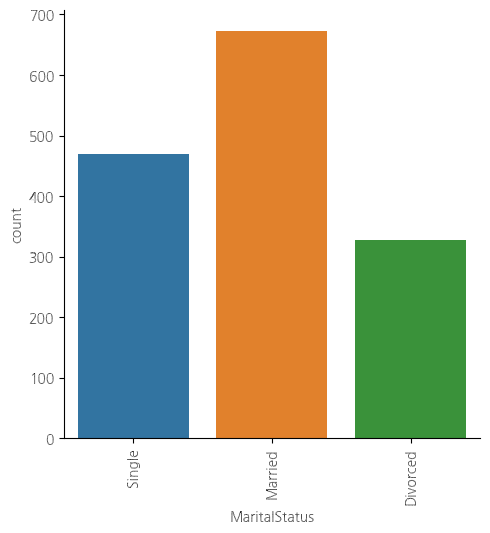

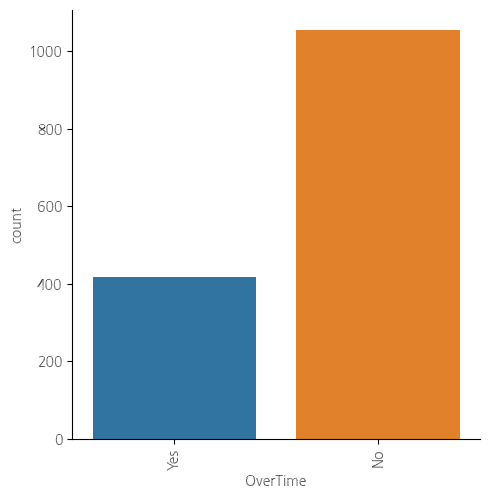

In [23]:
for col in attrition_cat.columns:
  fig = sns.catplot(x=col, kind='count', data=attrition_cat, hue=None)
  fig.set_xticklabels(rotation=90)
  plt.show()

Feature의 개수가 인코딩에 적합한가  
- Feature를 인코딩했을 때 메모리 문제가 발생하지는 않는가?

> Feature 인코딩  
> - LabelEncoder: LabelEncoder는 선향성을 가지는 머신러닝 기법에 쓰면 좋지 않음   
  (범주형 데이터는 순서에 대한 의미를 가지면 좋지 않음. 카테고리가 2개로 분류되면 LabelEncoder를 써도 괜찮으나 범주가 3개 이상인 경우 사용하지 않는 것이 좋은 경우가 많음)  
> - OneHotEncoder vs get_dummies

In [24]:
# get_dummies를 이용한 인코딩
attrition_cat_dummies = pd.get_dummies(attrition_cat)
attrition_cat_dummies.head(3)

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,0,0,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,1
1,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [25]:
# onehotencoder를 이용한 경우 - 가능한 경우들에 대해 컬럼을 모두 파악해야 함
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
attrition_cat_ohe = ohe.fit_transform(attrition_cat).toarray()
attrition_cat_ohe = pd.DataFrame(attrition_cat_ohe)
attrition_cat_ohe.columns = ['BusinessTravel_Non-Travel', 'BusinessTravel_Travel_Frequently',
       'BusinessTravel_Travel_Rarely', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'Gender_Female', 'Gender_Male', 'JobRole_Healthcare Representative',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
       'JobRole_Research Director', 'JobRole_Research Scientist',
       'JobRole_Sales Executive', 'JobRole_Sales Representative',
       'MaritalStatus_Divorced', 'MaritalStatus_Married',
       'MaritalStatus_Single', 'OverTime_No', 'OverTime_Yes']

print("OneHotEncoder 결과:")
attrition_cat_ohe.iloc[:, :2]

OneHotEncoder 결과:


,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently
0,0.0,0.0
1,0.0,1.0
2,0.0,0.0
3,0.0,1.0
4,0.0,0.0
...,...,...
1465,0.0,1.0
1466,0.0,0.0
1467,0.0,0.0
1468,0.0,1.0


### 상관성에 따른 Feature 정제  
#### 1) 숫자형 Feature  
- 데이터 확인
- 숫자형 컬럼들 간 Pearson R 상관 계수를 구함 (0.9 이상이면 의심해볼만 함)
- 상관 계수가 0.9 이상인 컬럼들 중 가장 큰 컬럼을 제거해 봄  
- 컬럼들 간 조합 생성: comb_num_feat = np.array(list(combinations(num_feat, 2)))
- Pearson R 상관 계수 구하기: pearson(x1, x2)[0]

데이터 확인

In [26]:
attrition_num.nunique().sort_values()

Attrition_numerical            2
PerformanceRating              2
WorkLifeBalance                4
EnvironmentSatisfaction        4
StockOptionLevel               4
JobInvolvement                 4
JobSatisfaction                4
RelationshipSatisfaction       4
Education                      5
JobLevel                       5
TrainingTimesLastYear          7
NumCompaniesWorked            10
PercentSalaryHike             15
YearsSinceLastPromotion       16
YearsWithCurrManager          18
YearsInCurrentRole            19
DistanceFromHome              29
YearsAtCompany                37
TotalWorkingYears             40
Age                           43
HourlyRate                    71
DailyRate                    886
MonthlyIncome               1349
MonthlyRate                 1427
dtype: int64

Feature 간 관계 시각화

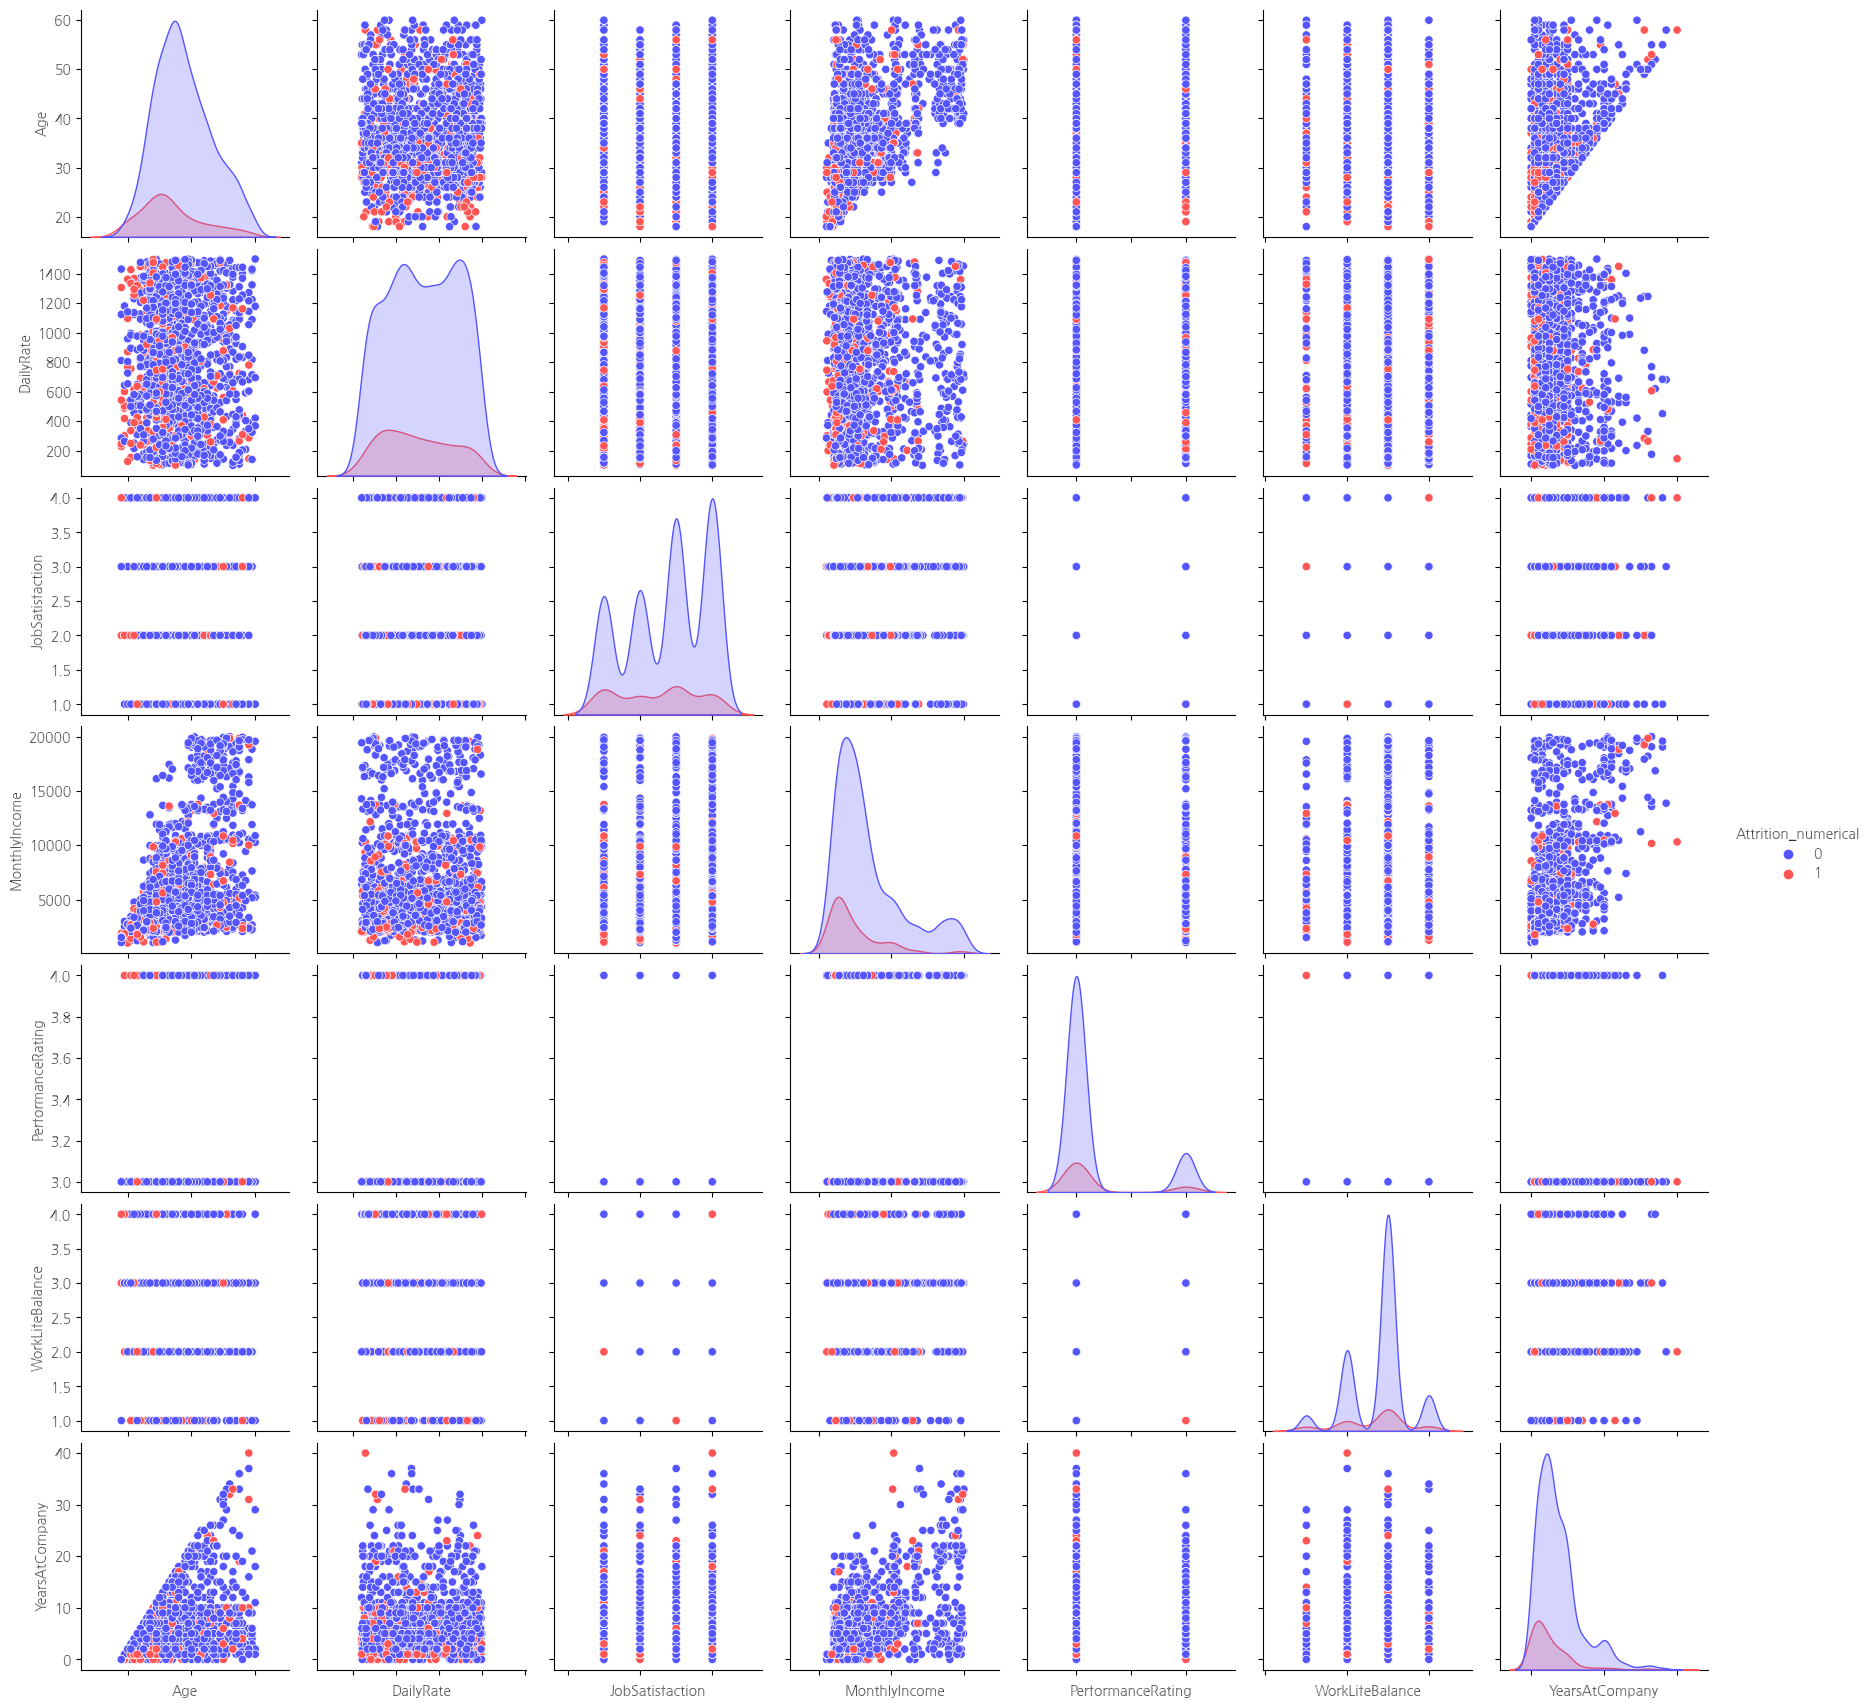

In [27]:
# Refining our list of numerical variables
numerical = [u'Age', u'DailyRate', u'JobSatisfaction', u'MonthlyIncome', u'PerformanceRating', u'WorkLifeBalance',
             u'YearsAtCompany', u'Attrition_numerical']

g = sns.pairplot(attrition[numerical], hue='Attrition_numerical',
                 palette='seismic', diag_kind='kde', diag_kws=dict(shade=True))
g.set(xticklabels=[])

상관계수 구하기
- 방법 1

In [28]:
num_feat = attrition_num.columns.values
comb_num_feat = np.array(list(combinations(num_feat, 2)))
corr_num_feat = np.array([])
for comb in comb_num_feat:
  corr = pearsonr(attrition_num[comb[0]], attrition_num[comb[1]])[0]
  corr_num_feat = np.append(corr_num_feat, corr)

In [29]:
high_corr_num = comb_num_feat[np.abs(corr_num_feat) >= 0.9]
high_corr_num

array([['JobLevel', 'MonthlyIncome']], dtype='<U24')

- 방법 2

In [30]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pio.renderers
pio.renderers.default = 'colab'
pio.renderers

data = [
    go.Heatmap(
        z=attrition_num.astype(float).corr().values,   # 피어슨 상관계수
        x=attrition_num.columns.values,
        y=attrition_num.columns.values,
        colorscale='Viridis',
        reversescale=False,
        opacity=1.0
    )
]

layout = go.Layout(
    title='숫자형 Feature들의 피어슨 상관계수',
    xaxis=dict(ticks='', nticks=36),
    yaxis=dict(ticks=''),
    width=900, height=700
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')

Feature 제거

In [31]:
attrition_num = attrition_num.drop(np.unique(high_corr_num[:, 0]), axis=1, errors='ignore')

#### 4) 범주형 Feature
데이터 확인  

In [32]:
attrition_cat_dummies.nunique().sort_values()

BusinessTravel_Non-Travel            2
MaritalStatus_Single                 2
MaritalStatus_Married                2
MaritalStatus_Divorced               2
JobRole_Sales Representative         2
JobRole_Sales Executive              2
JobRole_Research Scientist           2
JobRole_Research Director            2
JobRole_Manufacturing Director       2
JobRole_Manager                      2
JobRole_Laboratory Technician        2
JobRole_Human Resources              2
JobRole_Healthcare Representative    2
Gender_Male                          2
Gender_Female                        2
EducationField_Technical Degree      2
EducationField_Other                 2
EducationField_Medical               2
EducationField_Marketing             2
EducationField_Life Sciences         2
EducationField_Human Resources       2
Department_Sales                     2
Department_Research & Development    2
Department_Human Resources           2
BusinessTravel_Travel_Rarely         2
BusinessTravel_Travel_Fre

In [33]:
attrition_cat_dummies.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,0,0,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,1
1,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
4,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [34]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_V(var1, var2):
  crosstab = np.array(pd.crosstab(var1, var2, rownames=None, colnames=None))    # Cross table building
  stat = chi2_contingency(crosstab)[0]          # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab)        # Number of observations
  mini = min(crosstab.shape)-1    # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [35]:
rows = []

for var1 in attrition_cat_dummies:
  col = []
  for var2 in attrition_cat_dummies:
    cramers = cramers_V(attrition_cat_dummies[var1], attrition_cat_dummies[var2])   # Cramer's V test
    col.append(round(cramers, 2))     # Keeping of the rounded value of the Cramer's V
  rows.append(col)

cramers_results = np.array(rows)
corr_cat_dummies_feat = pd.DataFrame(cramers_results, columns = attrition_cat_dummies.columns, index=attrition_cat_dummies.columns)

corr_cat_dummies_feat.head()

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
BusinessTravel_Non-Travel,0.99,0.03,0.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
BusinessTravel_Travel_Frequently,0.03,1.00,0.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
BusinessTravel_Travel_Rarely,0.27,0.56,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0
Department_Human Resources,0.00,0.00,0.00,0.98,0.08,0.02,0.40,0.00,0.00,0.00,...,0.00,0.00,0.01,0.01,0.00,0.0,0.0,0.0,0.0,0.0
Department_Research & Development,0.00,0.00,0.00,0.08,1.00,0.82,0.03,0.02,0.23,0.03,...,0.06,0.03,0.13,0.54,0.11,0.0,0.0,0.0,0.0,0.0


In [36]:
# high_corr_num = comb_cat_dummies_feat[np.abs(corr_cat_dummies_feat) >= 0.9]
# high_corr_num

In [37]:
attrition_final = pd.concat([attrition_num, attrition_cat_dummies], axis=1)
attrition_final.head()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,41,1102,1,2,2,94,3,4,5993,19479,...,0,0,0,1,0,0,0,1,0,1
1,49,279,8,1,3,61,2,2,5130,24907,...,0,0,1,0,0,0,1,0,1,0
2,37,1373,2,2,4,92,2,3,2090,2396,...,0,0,0,0,0,0,0,1,0,1
3,33,1392,3,4,4,56,3,3,2909,23159,...,0,0,1,0,0,0,1,0,0,1
4,27,591,2,1,1,40,3,2,3468,16632,...,0,0,0,0,0,0,1,0,1,0


#### Target Feature 불균형 문제 처리
  
##### 1) 불균형 데이터 확인

In [38]:
data = [go.Bar(
    x=attrition["Attrition"].value_counts().index.values,
    y=attrition["Attrition"].value_counts().values
)]

py.iplot(data, filename='basic-bar')

##### 2) SMOTE를 이용한 오버 샘플링 적용
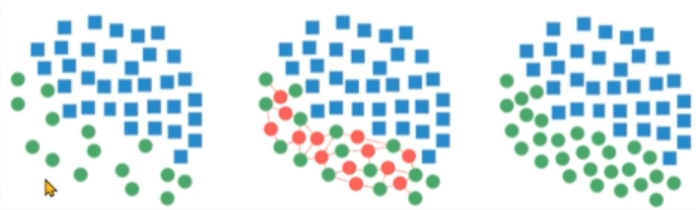

In [39]:
target = attrition["Attrition_numerical"]

In [40]:
# Import the train_test_split method
from sklearn.model_selection import train_test_split

# Split data into train and test sets as well as for validation and testing
train, test, target_train, target_val = train_test_split(attrition_final,
                                                         target,
                                                         train_size=0.80,
                                                         random_state=0)

In [41]:
oversampler = SMOTE(random_state=0)
smote_train, smote_target = oversampler.fit_resample(train, target_train)

### 03. 메신러닝 모델링
1) 분석 목표는 '직원 이탈의 주요한 원인(Feature)'  
2) RandomForest 분류모델

GridSearchCV를 이용한 최적 Hyper Parameter 탐색

In [ ]:
from sklearn.model_selection import GridSearchCV

rf_params = {'n_estimators': [10, 100],
             'max_depth': [4, 8, 10, 12],
             'min_samples_leaf': [2, 4, 8, 12],
             'max_features': [0.1, 0.3, 0.5]
             }

# RandomForest Classifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=rf_params, cv=3, n_jobs=-1)
grid_cv.fit(smote_train, smote_target)

print('최적 하이퍼파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

In [49]:
seed = 0
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 10,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'max_features': 0.3,
    'random_state': seed,
    'verbose': 0
}

In [55]:
rf = RandomForestClassifier(**rf_params)
rf.fit(smote_train, smote_target)
rf_predictions = rf.predict(test)

In [57]:
rf.feature_importances_

array([2.02540298e-03, 9.81880291e-04, 0.00000000e+00, 1.88969978e-03,
       8.62637556e-03, 0.00000000e+00, 1.40422518e-04, 1.13285948e-02,
       0.00000000e+00, 1.78660595e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.27000545e-02,
       0.00000000e+00, 4.37609459e-03, 0.00000000e+00, 2.09180030e-03,
       0.00000000e+00, 4.03948314e-03, 7.78883070e-01, 0.00000000e+00,
       0.00000000e+00, 1.93106208e-03, 0.00000000e+00, 7.06071347e-03,
       8.53324860e-03, 0.00000000e+00, 6.08359052e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.11499575e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.05821668e-03, 0.00000000e+00, 2.64583374e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.49872947e-04, 1.32709840e-01, 8.91837286e-03])

모델 성능

In [58]:
print("Accuracy score: {}".format(accuracy_score(target_val, rf_predictions)))
print("="*60)
print(classification_report(target_val, rf_predictions))

Accuracy score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       245
           1       1.00      1.00      1.00        49

    accuracy                           1.00       294
   macro avg       1.00      1.00      1.00       294
weighted avg       1.00      1.00      1.00       294



3) Gradient Boosting 분류 모델
  - GradientSearchCV를 이용한 최적 Hyper Parameter 탐색

In [59]:
from sklearn.model_selection import GridSearchCV

gb_params = {'n_estimators': [1000, 1500],
             'max_depth': [4, 6],
             'min_samples_leaf': [2, 4],
             'max_features': [0.7, 0.9],
             'learning_rate': [0.25, 0.3]
             }

# GradientBoosting Classifier 객체 생성 후 GridSearchCV 수행
gb_clf = GradientBoostingClassifier(random_state=0)
grid_cv = GridSearchCV(gb_clf, param_grid=gb_params, cv=3, n_jobs=-1)
grid_cv.fit(smote_train, smote_target)

print('최적 하이퍼파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼파라미터:  {'learning_rate': 0.25, 'max_depth': 4, 'max_features': 0.7, 'min_samples_leaf': 2, 'n_estimators': 1000}
최고 예측 정확도: 1.0000


In [60]:
# Gradient Boosting Parameters
seed = 0
gb_params = {
    'n_estimators': 1000,
    'max_depth': 4,
    'min_samples_leaf': 2,
    'max_features': 0.9,
    'learning_rate': 0.25,
    'random_state': seed,
    'verbose': 0
}

In [61]:
gb = GradientBoostingClassifier(**gb_params)
gb.fit(smote_train, smote_target)
gb_predictions = gb.predict(test)

모델 성능

In [62]:
print("Accuracy score: {}".format(accuracy_score(target_val, gb_predictions)))
print("="*60)
print(classification_report(target_val, gb_predictions))

Accuracy score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       245
           1       1.00      1.00      1.00        49

    accuracy                           1.00       294
   macro avg       1.00      1.00      1.00       294
weighted avg       1.00      1.00      1.00       294

